# Model Training Scripts #

### Env Setup

In [1]:
# Run first
import os
current_dir = os.path.dirname(os.path.dirname(os.path.abspath('model_training.ipynb')))
current_dir = os.path.join(current_dir, 'utils')

# System tools
import sys
sys.path.append(current_dir)


### Model Setup

In [2]:
### Dependencies

from model_utils import *
import os
import torch
import torch.nn as nn
from torchvision import models


### Vars

save_folder = os.path.join(os.path.dirname(current_dir), 'models')
model_name = 'classifier-aspp-20.pth'


### Script

dummy_input = torch.randn(1, 1, 512, 512)
model = Tiny_Classifier_A(num_classes= 1)
_ = model(dummy_input)

os.makedirs(save_folder, exist_ok= True)
save_path = os.path.join(save_folder, model_name)
torch.save(model.state_dict(), save_path)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Print the number of parameters
print(f"Total number of trainable parameters: {count_parameters(model):,}")

model_path = os.path.join(save_folder, 'classifier-aspp-20.pth')
model_name = 'classifier-aspp-21.pth'


Total number of trainable parameters: 197,569


### Data Loading & Preprocessing

In [3]:
### Dependencies

from data_utils import *
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

###  Vars

filtered_folder = "C:\\prgs\\ct-proc\\filtered"

threshold = 1999

transform_config = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

### Script

# Getting and loading the data
inputs, _, targets = load_images_f(filtered_folder)

# Check max
print(f"Image 'inputs' max: {np.max(inputs[0])}")
print(f"Image 'targets' max: {np.max(targets[0])}")

# Masking the image (prior to preprocessing)
inputs, targets = mask_images(inputs, targets, threshold)

# Check max
print(f"Image 'inputs' max: {np.max(inputs[0])}")
print(f"Image 'targets' max: {np.max(targets[0])}")

# Formating and preprocessing each image
image_class_1 = [format_image(i) for i in inputs]
image_class_2 = [format_image(i) for i in targets]

# Creating labels for each image (correct for torch.nn.crossentropyloss)
label_class_1 = [1] * len(image_class_1)
label_class_2 = [0 for _ in range(len(image_class_2))]

# Stack inputs and labels together correspondingly
image_set = image_class_1 + image_class_2
label_set = label_class_1 + label_class_2

# Transform to tensor and normalize each input sample
image_set = [transform_config(i) for i in image_set]

# Stack together
image_set = torch.stack(image_set)

# Check dataset shape
print(f"Total dataset size: {image_set.shape} samples")

# Splitting and setting up the data for model training
training_inputs, validation_inputs, training_labels, validation_labels = train_test_split(image_set, label_set, test_size= 0.5, random_state= 32)

print(f"Total training split size: {training_inputs.shape} samples")

# Creating custom dataset to pass data into dataloader
training_set = CustomDataset(training_inputs, training_labels)
valid_set = CustomDataset(validation_inputs, validation_labels)


Image 'inputs' max: 22840.775390625
Image 'targets' max: 1604.88623046875
Image 'inputs' max: 0.999422013759613
Image 'targets' max: 0.8422914147377014
Total dataset size: torch.Size([4498, 1, 512, 512]) samples
Total training split size: torch.Size([2249, 1, 512, 512]) samples


### Training Routine

GPU can be seen
Cudatoolkit version:  11.8
Epoch 1 of 100
Loss: 0.6936, Accuracy: 0.51
Epoch 2 of 100
Loss: 0.6934, Accuracy: 0.51
Epoch 3 of 100
Loss: 0.6935, Accuracy: 0.51
Epoch 4 of 100
Loss: 0.6931, Accuracy: 0.51
Epoch 5 of 100
Loss: 0.6913, Accuracy: 0.54
Epoch 6 of 100
Loss: 0.6891, Accuracy: 0.58
Epoch 7 of 100
Loss: 0.6861, Accuracy: 0.60
Epoch 8 of 100
Loss: 0.6807, Accuracy: 0.62
Epoch 9 of 100
Loss: 0.6728, Accuracy: 0.61
Epoch 10 of 100
Loss: 0.6677, Accuracy: 0.64
Epoch 11 of 100
Loss: 0.6602, Accuracy: 0.65
Epoch 12 of 100
Loss: 0.6531, Accuracy: 0.66
Epoch 13 of 100
Loss: 0.6476, Accuracy: 0.67
Epoch 14 of 100
Loss: 0.6444, Accuracy: 0.66
Epoch 15 of 100
Loss: 0.6427, Accuracy: 0.68
Epoch 16 of 100
Loss: 0.6421, Accuracy: 0.68
Epoch 17 of 100
Loss: 0.6421, Accuracy: 0.68
Epoch 18 of 100
Loss: 0.6419, Accuracy: 0.66
Epoch 19 of 100
Loss: 0.6413, Accuracy: 0.67
Epoch 20 of 100
Loss: 0.6372, Accuracy: 0.67
Epoch 21 of 100
Loss: 0.6339, Accuracy: 0.67
Epoch 22 of 100
Loss:

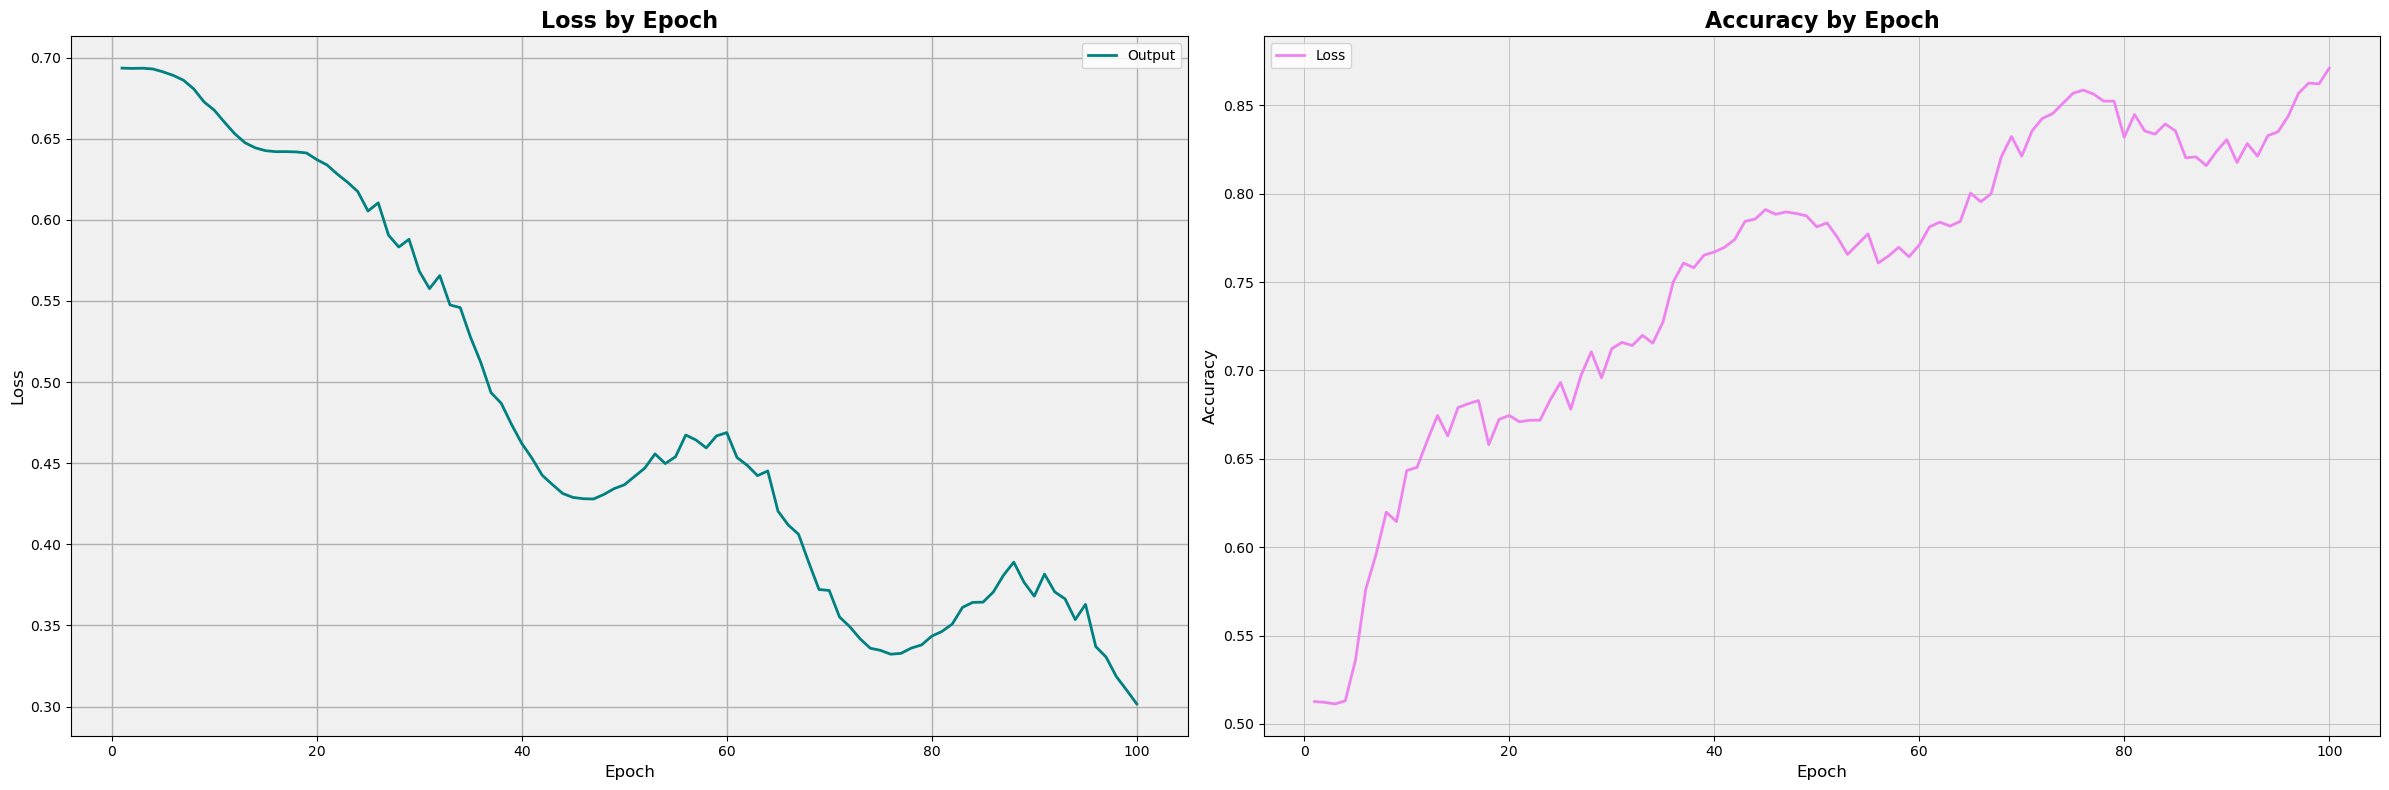

Accuracy of validation set: 86.57%


In [4]:
### Vars

batch_size = 2
num_classes = 1
num_epochs = 100

### Script

# Loading data into dataloader for training
training_data = DataLoader(training_set, batch_size= batch_size, shuffle= True, num_workers= 4)
valid_data = DataLoader(valid_set, batch_size= batch_size, shuffle= True, num_workers= 4)

# Model setup

# Check if cuda can be seen
print('GPU can be seen') if torch.cuda.is_available() else print('GPU not seen')
print('Cudatoolkit version: ', torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading up the classifier model
classifier = Tiny_Classifier_A(num_classes)
classifier.load_state_dict(torch.load(model_path))

# Set loss, optimizer, and scheduler
pos_weight = torch.tensor([1.0]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight= pos_weight)
optimizer = optim.Adam(classifier.parameters(), lr= 1e-4, weight_decay= 1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Load onto device
classifier.to(device)

# Running training and validation loop
training_loop_2(classifier, training_data, loss_fn, optimizer, scheduler, num_epochs, device)
validation_loop_2(classifier, valid_data, device)

# Saving the model
os.makedirs(save_folder, exist_ok= True)
save_path = os.path.join(save_folder, model_name)
torch.save(classifier.state_dict(), save_path)

# Environment cleanup
torch.cuda.empty_cache()

GPU can be seen
Cudatoolkit version:  11.8
Epoch 1 of 50
Loss: 0.4523, Accuracy: 0.77
Epoch 2 of 50
Loss: 0.4510, Accuracy: 0.78
Epoch 3 of 50
Loss: 0.4466, Accuracy: 0.78
Epoch 4 of 50
Loss: 0.4344, Accuracy: 0.78
Epoch 5 of 50
Loss: 0.4246, Accuracy: 0.79
Epoch 6 of 50
Loss: 0.4257, Accuracy: 0.79
Epoch 7 of 50
Loss: 0.4081, Accuracy: 0.80
Epoch 8 of 50
Loss: 0.4020, Accuracy: 0.79
Epoch 9 of 50
Loss: 0.3946, Accuracy: 0.80
Epoch 10 of 50
Loss: 0.3901, Accuracy: 0.81
Epoch 11 of 50
Loss: 0.3863, Accuracy: 0.81
Epoch 12 of 50
Loss: 0.3802, Accuracy: 0.81
Epoch 13 of 50
Loss: 0.3763, Accuracy: 0.82
Epoch 14 of 50
Loss: 0.3739, Accuracy: 0.81
Epoch 15 of 50
Loss: 0.3707, Accuracy: 0.82
Epoch 16 of 50
Loss: 0.3700, Accuracy: 0.82
Epoch 17 of 50
Loss: 0.3710, Accuracy: 0.82
Epoch 18 of 50
Loss: 0.3727, Accuracy: 0.82
Epoch 19 of 50
Loss: 0.3746, Accuracy: 0.81
Epoch 20 of 50
Loss: 0.3771, Accuracy: 0.80
Epoch 21 of 50
Loss: 0.3809, Accuracy: 0.81
Epoch 22 of 50
Loss: 0.3791, Accuracy: 0.8

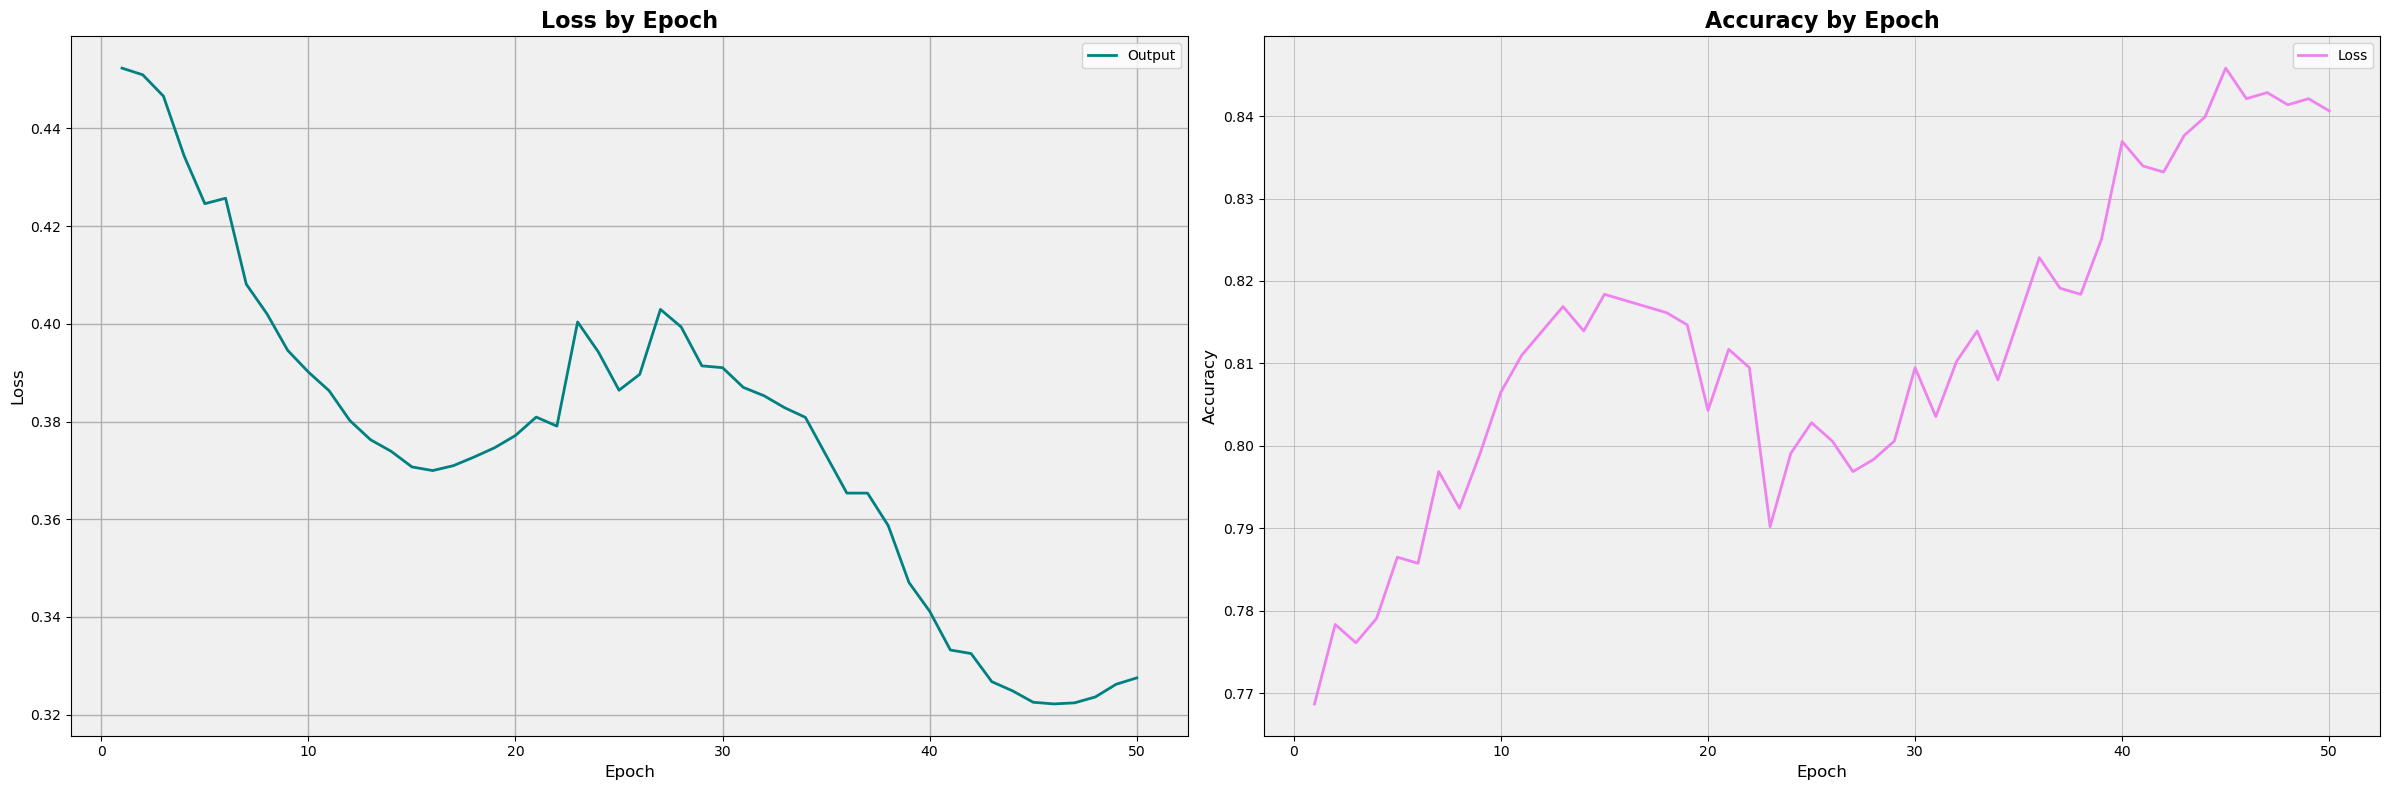

Accuracy of validation set: 81.93%


In [12]:
model_path = os.path.join(save_folder, 'classifier-sm-01.pth')
model_name = 'classifier-sm-02.pth'

### Vars

batch_size = 2
num_classes = 1
num_epochs = 50

### Script

# Loading data into dataloader for training
training_data = DataLoader(training_set, batch_size= batch_size, shuffle= True, num_workers= 4)
valid_data = DataLoader(valid_set, batch_size= batch_size, shuffle= True, num_workers= 4)

# Model setup

# Check if cuda can be seen
print('GPU can be seen') if torch.cuda.is_available() else print('GPU not seen')
print('Cudatoolkit version: ', torch.version.cuda)

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading up the classifier model
classifier = Tiny_Classifier_SM(num_classes)
classifier.load_state_dict(torch.load(model_path))

# Set loss, optimizer, and scheduler
pos_weight = torch.tensor([1.0]).to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight= pos_weight)
optimizer = optim.Adam(classifier.parameters(), lr= 1e-4, weight_decay= 1e-6)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

# Load onto device
classifier.to(device)

# Running training and validation loop
training_loop_2(classifier, training_data, loss_fn, optimizer, scheduler, num_epochs, device)
validation_loop_2(classifier, valid_data, device)

# Saving the model
os.makedirs(save_folder, exist_ok= True)
save_path = os.path.join(save_folder, model_name)
torch.save(classifier.state_dict(), save_path)

# Environment cleanup
torch.cuda.empty_cache()